In [166]:
import os
import pandas as pd
import matplotlib.pyplot as plt
os.chdir("E:\Monash_assignments")
path = r"E:\Monash_assignments\Portfolio\Portfolio\Project_1 covid\data\raw\owid-covid-data.csv"
df = pd.read_csv(path, parse_dates=["date"], low_memory= False)

<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
C:\Users\athar\AppData\Local\Temp\ipykernel_20132\656091010.py:4: SyntaxWarning: invalid escape sequence '\M'
  os.chdir("E:\Monash_assignments")


In [167]:
print(df.shape)
df.columns.tolist()[:10]
df.isna().mean().sort_values(ascending=False).head(10)

(429435, 67)


weekly_icu_admissions_per_million          0.974401
weekly_icu_admissions                      0.974401
excess_mortality_cumulative_per_million    0.968771
excess_mortality                           0.968771
excess_mortality_cumulative                0.968771
excess_mortality_cumulative_absolute       0.968771
weekly_hosp_admissions_per_million         0.942955
weekly_hosp_admissions                     0.942955
icu_patients                               0.908913
icu_patients_per_million                   0.908913
dtype: float64

date
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    0.0
2020-01-04    0.0
2020-01-05    9.0
             ... 
2024-08-10    0.0
2024-08-11    0.0
2024-08-12    0.0
2024-08-13    0.0
2024-08-14    0.0
Name: new_cases, Length: 1688, dtype: float64


<Axes: title={'center': 'Global Daily New COVID-19 Cases Till 2024'}, xlabel='date'>

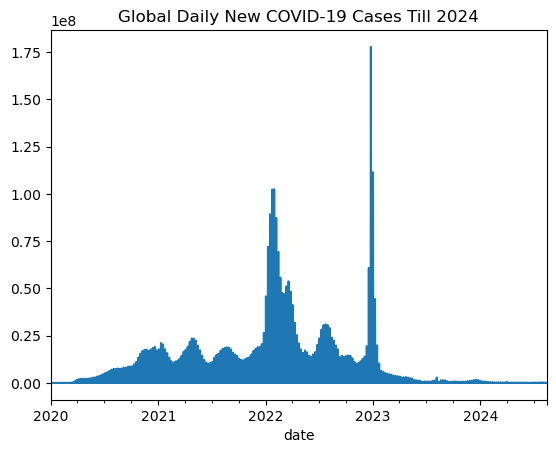

In [168]:
global_ts = df.groupby("date")["new_cases"].sum()
print(global_ts)
global_ts.plot(title="Global Daily New COVID-19 Cases Till 2024")

<Axes: title={'center': '7-Day Rolling Avg of Global New Cases'}, xlabel='date'>

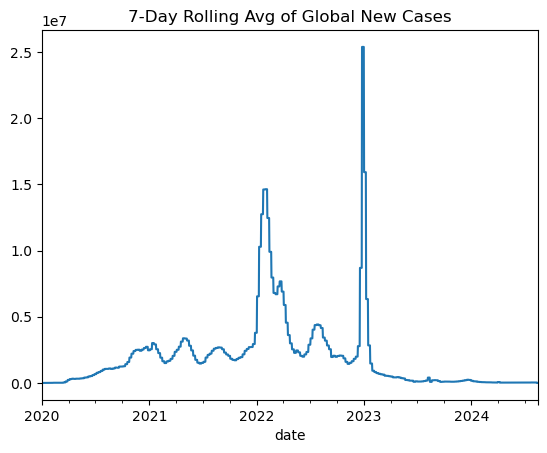

In [169]:
global_ts.rolling(7).mean().plot(title="7-Day Rolling Avg of Global New Cases")

In [170]:
#grouping the data by continent and date 
Continent_ts = df.groupby(["date","continent"])["new_cases"].sum().reset_index()
#creating a pivot table with dates as index and continents as columns with values of new cases
continent_pivot = Continent_ts.pivot(index="date",columns="continent",values="new_cases")

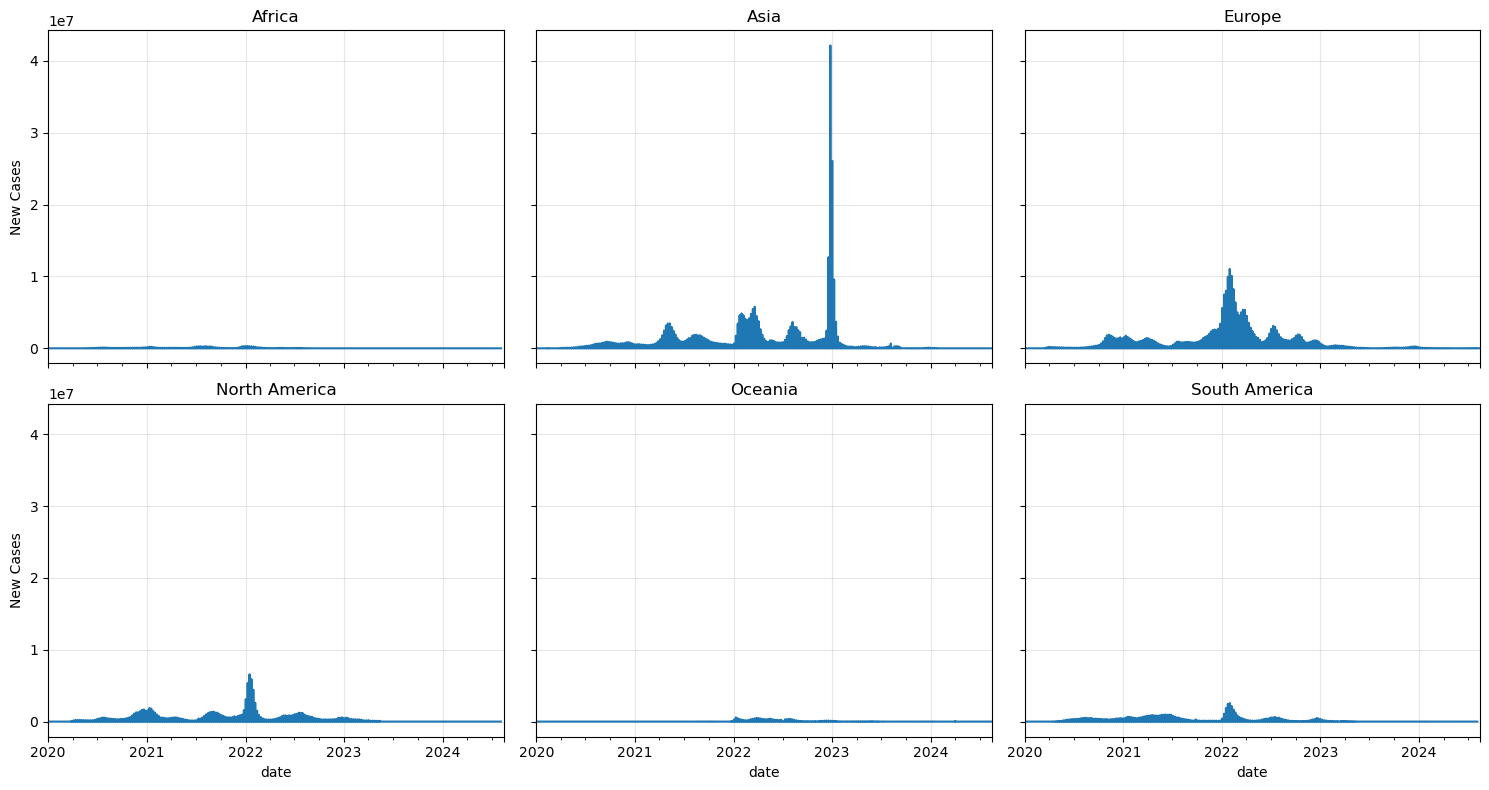

In [171]:
#plot each continent's trend in its own subplot 3 cloumns and 2 rows 
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(15,8), sharex= True, sharey=True)
axes = axes.flatten()
for ax,(continent,series) in zip(axes, continent_pivot.items()):
    series.plot(ax=ax,title =continent)
    ax.set_ylabel("New Cases")
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [172]:
# For each continent, find the date with the maximum daily new cases
peak_info = (
    Continent_ts
    .loc[Continent_ts.groupby("continent")["new_cases"].idxmax()]
    .rename(columns={"new_cases": "peak_cases"})
    .set_index("continent")[["peak_cases", "date"]]
)

print(peak_info)


               peak_cases       date
continent                           
Africa           316014.0 2022-01-09
Asia           42142424.0 2022-12-25
Europe         11040888.0 2022-01-30
North America   6582043.0 2022-01-16
Oceania          593626.0 2022-01-09
South America   2570599.0 2022-01-30


In [173]:
# 1. Make sure 'new_cases_per_million' exists; if not, compute it:
if "new_cases_per_million" not in df.columns:
    df["new_cases_per_million"] = df["new_cases"] / (df["population"] / 1_000_000)

# 2. For each country, find the date and value of its maximum new_cases_per_million
peak_df = (
    df
    .loc[~df["new_cases_per_million"].isna()]  # drop NaNs
    .groupby("location")
    .apply(lambda x: x.loc[x["new_cases_per_million"].idxmax(), ["new_cases_per_million", "date"]])
    .reset_index()
)
peak_df.columns = ["location", "peak_cases_per_million", "peak_date"]

# 3. Select the top 10 countries by peak_cases_per_million
top10 = peak_df.sort_values("peak_cases_per_million", ascending=False).head(10)
top10


C:\Users\athar\AppData\Local\Temp\ipykernel_20132\3851681433.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.loc[x["new_cases_per_million"].idxmax(), ["new_cases_per_million", "date"]])


,location,peak_cases_per_million,peak_date
185,Saint Helena,241758.23,2022-09-25
241,Wallis and Futuna,230762.55,2022-10-16
135,Marshall Islands,226617.45,2022-08-21
72,Falkland Islands,208819.34,2022-05-15
151,Nauru,173843.16,2022-06-26
227,Tuvalu,109468.64,2022-11-13
189,Saint Pierre and Miquelon,100173.61,2022-03-27
73,Faroe Islands,92026.13,2022-02-06
175,Pitcairn,88888.89,2022-07-24
159,Niue,84056.40,2023-01-08


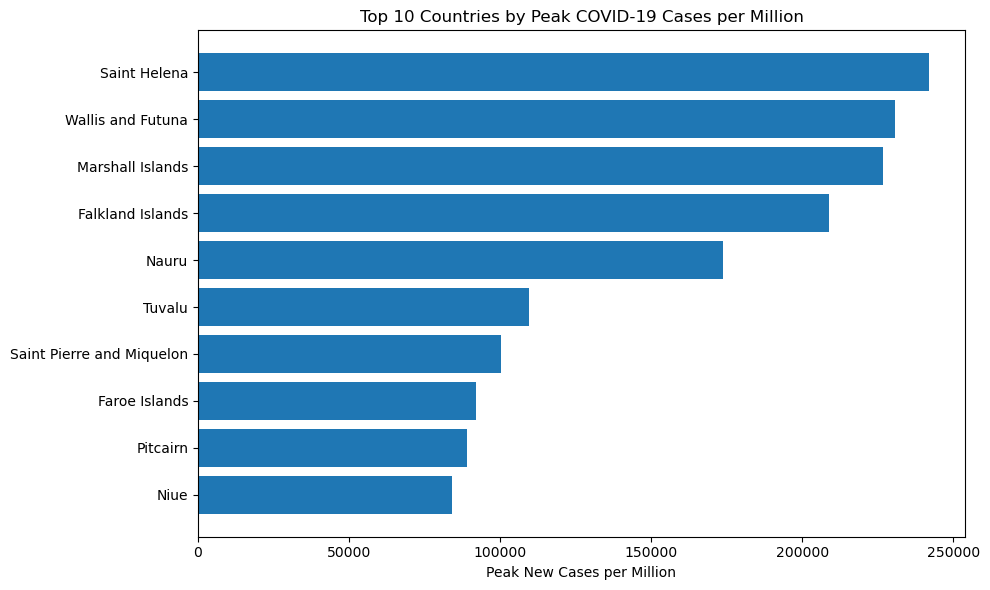

In [174]:
plt.figure(figsize=(10, 6))
plt.barh(top10["location"][::-1], top10["peak_cases_per_million"][::-1])
plt.xlabel("Peak New Cases per Million")
plt.title("Top 10 Countries by Peak COVID-19 Cases per Million")
plt.tight_layout()
plt.show()


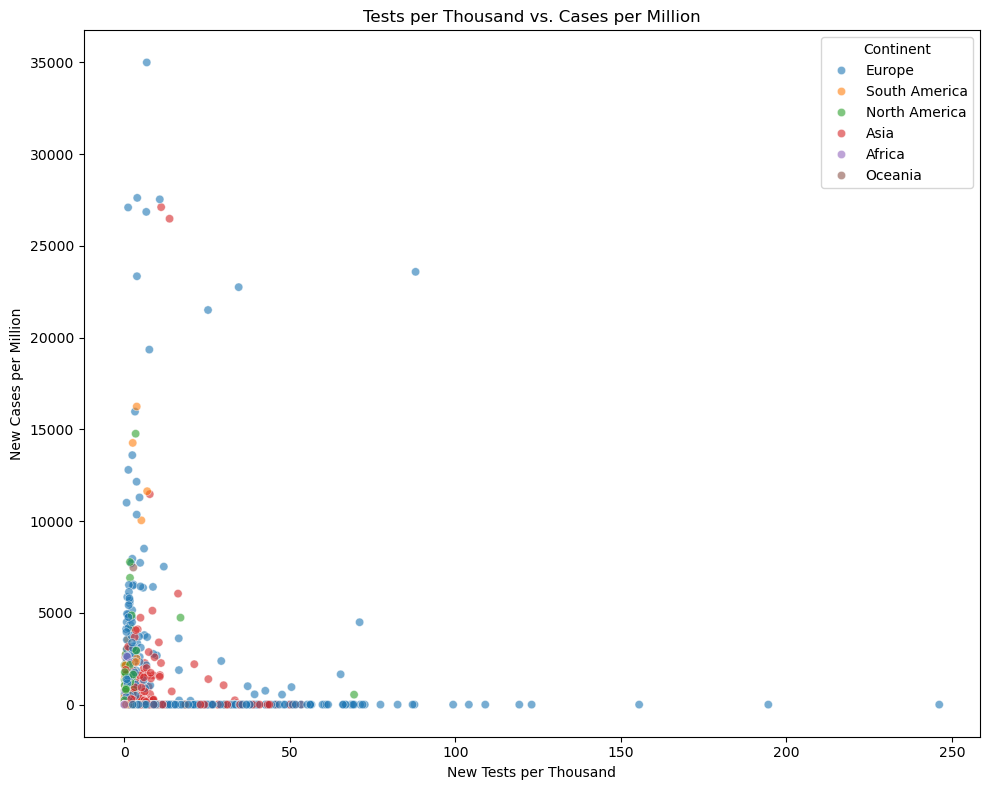

In [175]:
import seaborn as sns

# Subset to rows where both metrics exist
mask = df["new_tests_per_thousand"].notna() & df["new_cases_per_million"].notna()
df_scatter = df.loc[mask, ["date", "location", "continent",
                           "new_tests_per_thousand", "new_cases_per_million"]]

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_scatter.sample(5000, random_state=1),  # sample for readability
    x="new_tests_per_thousand",
    y="new_cases_per_million",
    hue="continent",
    alpha=0.6
)
plt.title("Tests per Thousand vs. Cases per Million")
plt.xlabel("New Tests per Thousand")
plt.ylabel("New Cases per Million")
plt.legend(title="Continent", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [176]:
# Compute Pearson r per continent
corrs = (
    df_scatter
    .groupby("continent")
    .apply(lambda g: g[["new_tests_per_thousand", "new_cases_per_million"]]
           .corr().iloc[0,1])
    .reset_index(name="pearson_r")
)
print(corrs)


       continent  pearson_r
0         Africa   0.192019
1           Asia   0.086353
2         Europe   0.040361
3  North America   0.012983
4        Oceania   0.020796
5  South America   0.158219


C:\Users\athar\AppData\Local\Temp\ipykernel_20132\601760797.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[["new_tests_per_thousand", "new_cases_per_million"]]


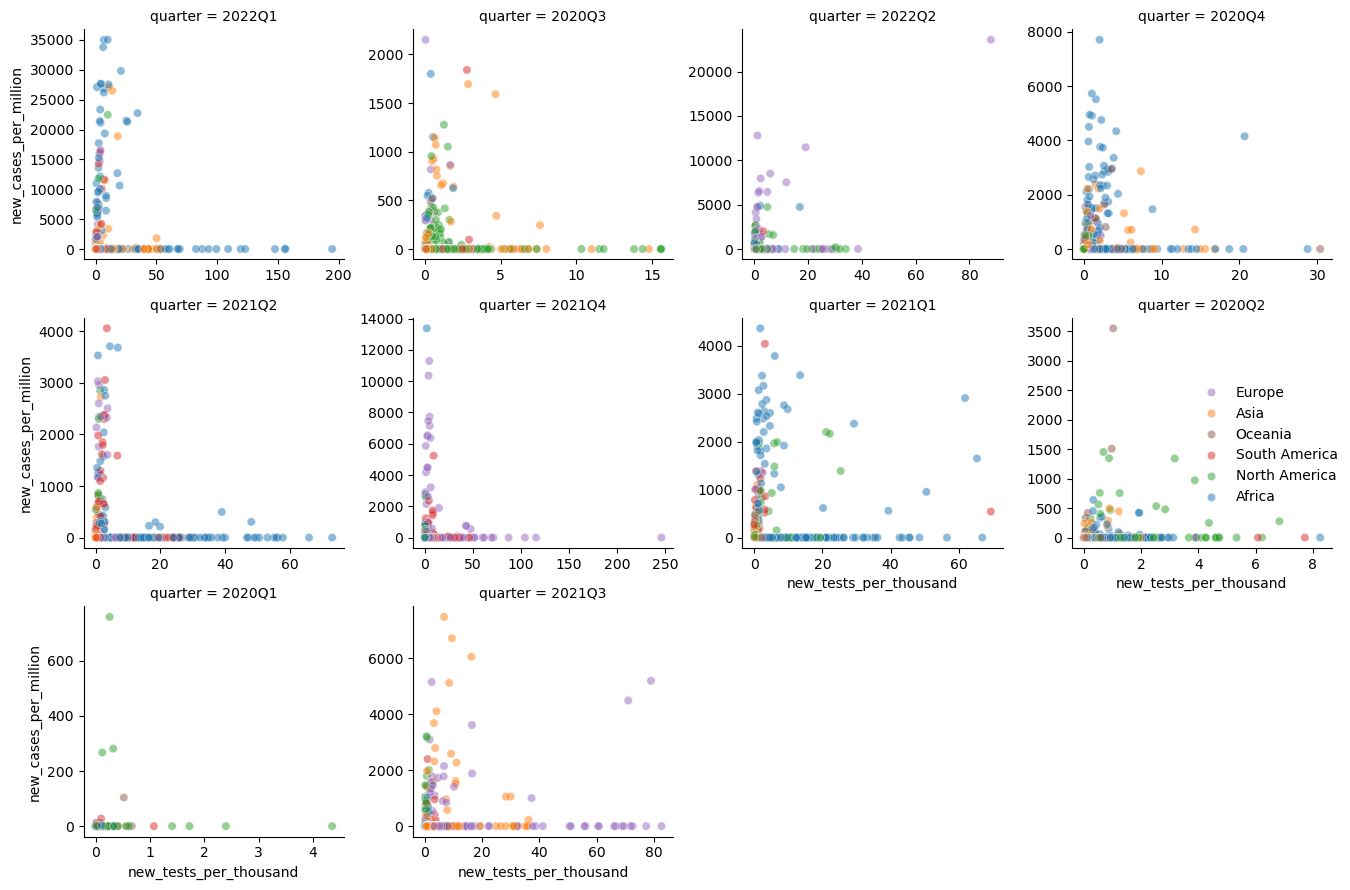

In [177]:
df_scatter["quarter"] = df_scatter["date"].dt.to_period("Q")
g = sns.FacetGrid(df_scatter.sample(8000, random_state=1), 
                  col="quarter", col_wrap=4, height=3, sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot,
                "new_tests_per_thousand", "new_cases_per_million", "continent", alpha=0.5)
g.add_legend()
plt.tight_layout()


In [178]:


# 1. Compute per-country coverage for each key field
coverage_df = (
    df
    .groupby("location")
    .agg(
        days_total=("date", "nunique"),
        days_with_cases=("new_cases", lambda x: x.notna().sum()),
        days_with_tests=("new_tests", lambda x: x.notna().sum()),
        days_with_pop=("population", lambda x: x.notna().sum())
    )
    .assign(
        pct_cases=lambda d: d["days_with_cases"] / d["days_total"],
        pct_tests=lambda d: d["days_with_tests"] / d["days_total"],
        pct_pop=lambda d: d["days_with_pop"] / d["days_total"]
    )
    .reset_index()
)

# 2. View the worst-coverage countries
coverage_df.sort_values("pct_tests").head(10)


,location,days_total,days_with_cases,days_with_tests,days_with_pop,pct_cases,pct_tests,pct_pop
0,Afghanistan,1674,1674,0,1674,1.000000,0.0,1.0
124,Liberia,1674,1673,0,1674,0.999403,0.0,1.0
119,Kyrgyzstan,1674,1674,0,1674,1.000000,0.0,1.0
206,Sint Maarten (Dutch part),1674,1673,0,1674,0.999403,0.0,1.0
116,Kiribati,1674,1674,0,1674,1.000000,0.0,1.0
112,Jersey,1674,1674,0,1674,1.000000,0.0,1.0
209,Solomon Islands,1674,1674,0,1674,1.000000,0.0,1.0
210,Somalia,1674,1674,0,1674,1.000000,0.0,1.0
212,South America,1674,1674,0,1674,1.000000,0.0,1.0
107,Isle of Man,1674,1674,0,1674,1.000000,0.0,1.0


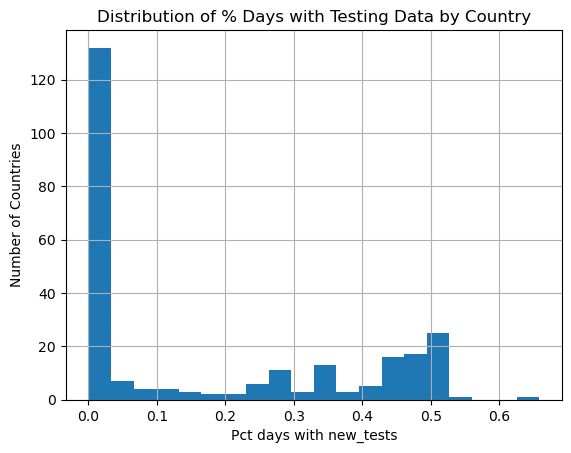

In [179]:
# Plot distribution of test-data coverage
coverage_df["pct_tests"].hist(bins=20)
plt.title("Distribution of % Days with Testing Data by Country")
plt.xlabel("Pct days with new_tests")
plt.ylabel("Number of Countries")
plt.show()



In [180]:
good_countries = coverage_df.query("pct_cases >= 0.9 and pct_tests >= 0.75")["location"]
df = df[df.location.isin(good_countries)]


In [181]:
coverage_df.to_csv("E:/Monash_assignments/Portfolio/Portfolio/Project_1 covid/data/cleaned/coverage_summary.csv", index=False)


In [182]:
# Forward-fill population within each country
df['population'] = df.groupby('location')['population'].fillna(method='ffill')

# Drop any rows still missing population
missing_pop = df['population'].isna().sum()
print(f"Rows without population: {missing_pop}")
df = df[df['population'].notna()]
df.head(5)

Rows without population: 0


C:\Users\athar\AppData\Local\Temp\ipykernel_20132\1239837967.py:2: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['population'] = df.groupby('location')['population'].fillna(method='ffill')


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million


In [183]:
def fill_gaps(group, col, max_gap=3):
    # forward-fill then backward-fill small runs
    filled = group[col].fillna(method='ffill', limit=max_gap)
    return filled

df['new_tests'] = df.groupby('location').apply(lambda g: fill_gaps(g, 'new_tests')).reset_index(level=0, drop=True)
df['new_cases'] = df.groupby('location').apply(lambda g: fill_gaps(g, 'new_cases')).reset_index(level=0, drop=True)


C:\Users\athar\AppData\Local\Temp\ipykernel_20132\3522847587.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['new_tests'] = df.groupby('location').apply(lambda g: fill_gaps(g, 'new_tests')).reset_index(level=0, drop=True)


ValueError: Columns must be same length as key

In [184]:
# Compute coverage
coverage = (
    df
    .groupby('location')['new_cases']
    .apply(lambda x: x.notna().mean())
)

# Countries meeting threshold
good_countries = coverage[coverage >= 0.9].index.tolist()
print(f"Countries retained: {len(good_countries)} / {coverage.size}")

# Filter
df = df[df['location'].isin(good_countries)]


Countries retained: 0 / 0
